In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import zipfile as zf
from skimage.io import imread
import h5py

In [2]:
%matplotlib inline

In [11]:
from keras.utils.io_utils import HDF5Matrix
base_h5_dir = ''
base_img_dir = ''

## THE MODEL

### Loading prepackaged image data

In [12]:
h5_path = os.path.join(base_h5_dir, 'deeplesion.h5')
with h5py.File(h5_path, 'r') as h:
    print(list(h.keys()))
    for k in ['image', 'mask']:
        print(k, h[k].shape, h[k].dtype)
    base_shape = h['image'].shape

['file_name', 'image', 'mask']
image (1350, 512, 512, 1) float64
mask (1350, 512, 512, 1) bool


In [13]:
ct_window_func = lambda x: np.clip((x+175.0)/275, -1, 1)
get_xyf = lambda s, e: (HDF5Matrix(h5_path, 'image', start=s, end=e, normalizer=ct_window_func), 
                       HDF5Matrix(h5_path, 'mask', start=s, end=e),
                       HDF5Matrix(h5_path, 'file_name', start=s, end=e)
                      )
train_split = 0.7
cut_val = int(base_shape[0]*train_split)
train_x, train_y, train_paths = get_xyf(0, cut_val)
test_x, test_y, test_paths = get_xyf(cut_val, None)
print(train_x.shape, test_x.shape)

(944, 512, 512, 1) (406, 512, 512, 1)


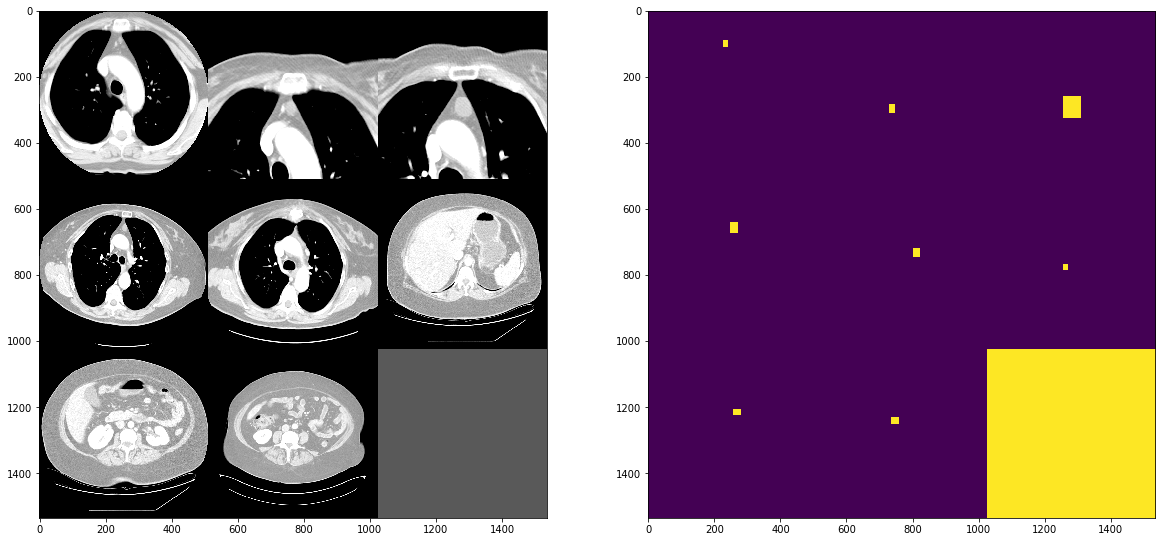

In [37]:
from skimage.util import montage
t_x, t_y = train_x[:8], train_y[:8]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(t_x[:, :, :, 0]), cmap = 'gray')
ax2.imshow(montage(t_y[:, :, :, 0]))

In [38]:
class DownsampledHDF5Matrix(HDF5Matrix):
    def __init__(self, datapath, dataset, downscale_factor, start=0, end=None, normalizer=None):
        ds_func = lambda x: x[:, ::downscale_factor, ::downscale_factor, :]
        ds_norm = ds_func if normalizer is None else lambda x: ds_func(normalizer(x))
        self.downscale_factor = downscale_factor
        super(DownsampledHDF5Matrix, self).__init__(datapath, dataset, start=start, end=end, normalizer=ds_norm)
        t_val = self[0:1]
        self._base_shape = t_val.shape[1:]
        self._base_dtype = t_val.dtype
    
    @property
    def shape(self):
        """Gets a numpy-style shape tuple giving the dataset dimensions.
        # Returns
            A numpy-style shape tuple. (self.data.shape[1]//self.downscale_factor, self.data.shape[2]//self.downscale_factor, self.data.shape[3])
        """
        return (self.end - self.start,) + self._base_shape
    
    @property
    def dtype(self):
        """Gets the datatype of the dataset.
        # Returns
            A numpy dtype string.
        """
        return self._base_dtype

(406, 512, 512, 1) (406, 128, 128, 1)


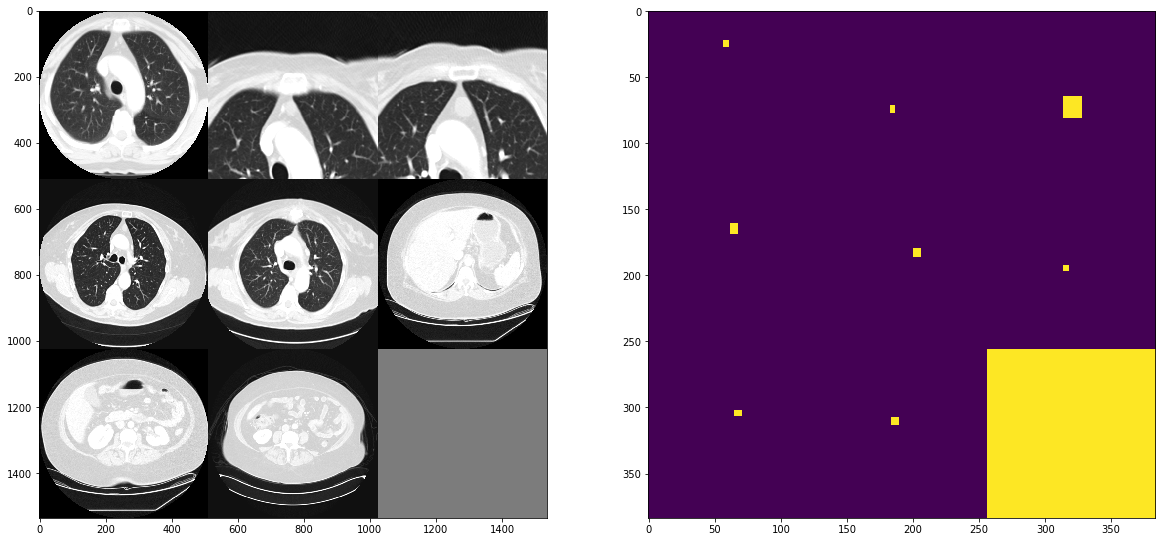

In [39]:
ct_window_func = lambda x: np.clip((x+500.0)/600, -1, 1)
get_xyf = lambda s, e: (HDF5Matrix(h5_path, 'image', start=s, end=e, normalizer=ct_window_func), 
                       DownsampledHDF5Matrix(h5_path, 'mask', downscale_factor=4, start=s, end=e),
                       [x.decode() for x in HDF5Matrix(h5_path, 'file_name', start=s, end=e)[:]]
                      )
train_split = 0.7
cut_val = int(base_shape[0]*train_split)
train_x, train_y, train_paths = get_xyf(0, cut_val)
test_x, test_y, test_paths = get_xyf(cut_val, None)
print(test_x.shape, test_y.shape)
t_x, t_y = train_x[:8], train_y[:8]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(t_x[:, :, :, 0]), cmap = 'gray')
ax2.imshow(montage(t_y[:, :, :, 0]))

In [40]:
## Loading the data

In [42]:
df = pd.read_csv(os.path.join(base_img_dir, 'DL_info.csv'))
df = df[df['File_name'].isin(train_paths+test_paths)]
df['training'] = df['File_name'].isin(train_paths)
df.sample(3)

,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,Possibly_noisy,Slice_range,Spacing_mm_px_,Image_size,DICOM_windows,Patient_gender,Patient_age,Train_Val_Test,training
462,000066_02_01_069.png,66,2,1,69,"309.514, 254.541, 271.568, 231.676, 304.649, 2...","266.568, 226.676, 314.514, 266.838","44.3025, 25.5302","0.571222, 0.455609, 0.666541",-1,0,"63, 75","0.757812, 0.757812, 5","512, 512","-175, 275",M,24.0,1,True
415,000062_18_01_059.png,62,18,1,59,"258.79, 210.804, 301.196, 221.405, 281.667, 23...","253.79, 191.296, 306.196, 243.703","43.7114, 42.5858","0.553306, 0.43768, 0.594548",-1,0,"52, 79","0.816406, 0.816406, 5","512, 512","-175, 275",M,71.0,1,True
12640,001227_04_02_044.png,1227,4,2,44,"208.838, 248.362, 139.059, 255.928, 169.881, 2...","134.059, 211.543, 213.838, 284.473","70.1883, 63.2986","0.330128, 0.529402, 0.372675",5,0,"14, 74","0.585938, 0.585938, 1","512, 512","-1500, 500",F,46.0,2,True


In [43]:
from keras.layers import Input, Activation, Conv2D, MaxPool2D, UpSampling2D, Dropout, concatenate, BatchNormalization, Cropping2D, ZeroPadding2D, SpatialDropout2D
from keras.layers import Conv2DTranspose, Dropout, GaussianNoise
from keras.models import Model
from keras import backend as K

In [44]:
def up_scale(in_layer):
    filt_count = in_layer._keras_shape[-1]
    return Conv2DTranspose(filt_count//2+2, kernel_size = (2,2), strides = (2,2), padding = 'same')(in_layer)
def up_scale_fancy(in_layer):
    return UpSampling2D(size=(2,2))(in_layer)

input_layer = Input(shape=train_x.shape[1:])
sp_layer = GaussianNoise(0.1)(input_layer)
bn_layer = BatchNormalization()(sp_layer)
c1 = Conv2D(filters=8, kernel_size=(5,5), activation='relu', padding='same')(bn_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

l = SpatialDropout2D(0.25)(c4)
dil_layers = [l]
for i in [2, 4, 6, 8, 12, 18, 24]:
    dil_layers += [Conv2D(16,
                          kernel_size = (3, 3), 
                          dilation_rate = (i, i), 
                          padding = 'same',
                         activation = 'relu')(l)]
l = concatenate(dil_layers)

l = SpatialDropout2D(0.2)(concatenate([up_scale(l), c3], axis=-1))
l = Conv2D(filters=128, kernel_size=(2,2), activation='linear', padding='same')(l)
l = BatchNormalization()(l)
l = Activation('relu')(l)
l = Conv2D(filters=96, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=16, kernel_size=(2,2), activation='linear', padding='same')(l)
l = Cropping2D((4,4))(l)
l = BatchNormalization()(l)
l = Activation('relu')(l)

l = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
output_layer = ZeroPadding2D((4,4))(l)

seg_model = Model(input_layer, output_layer)
seg_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 1)  4           gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  208         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [45]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [47]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [49]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 7.5, 
                  width_shift_range = 0.02, 
                  height_shift_range = 0.02, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.9, 1.1],
                  horizontal_flip = False, 
                  vertical_flip = False,
                  fill_mode = 'nearest',
                   data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)
dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)
def train_gen(batch_size = 16, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        batch_count = train_x.shape[0]//batch_size
        batch_id = np.random.permutation(range(0, train_x.shape[0]-batch_size, batch_size))
        for c_idx in batch_id:
            g_x = image_gen.flow(train_x[c_idx:(c_idx+batch_size)], batch_size = batch_size, seed = seed, shuffle=True)
            g_y = label_gen.flow(train_y[c_idx:(c_idx+batch_size)], batch_size = batch_size, seed = seed, shuffle=True)
            yield next(g_x)/255.0, next(g_y)

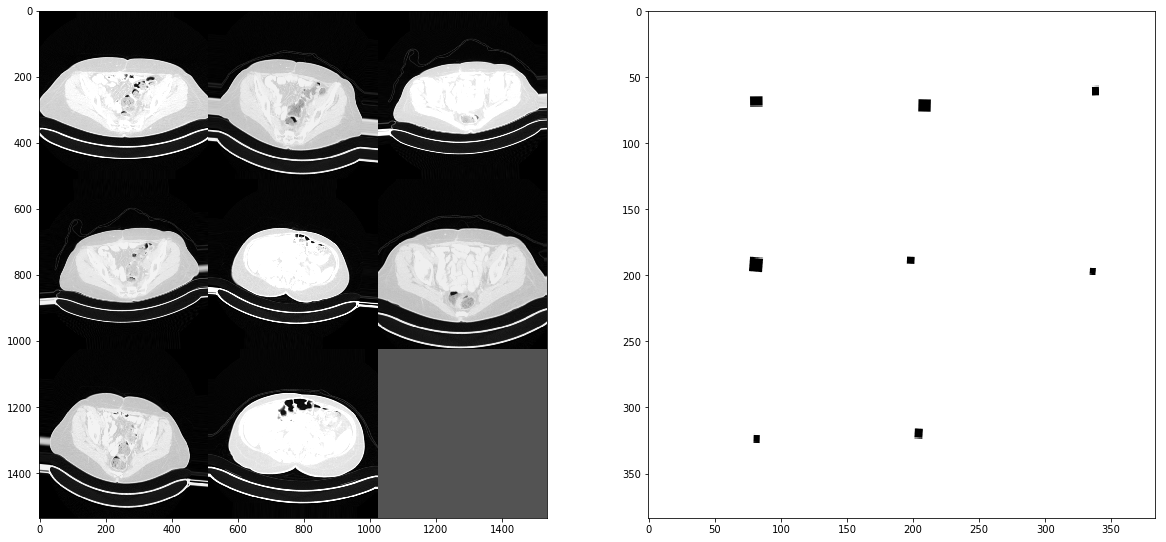

In [50]:
cur_gen = train_gen(8)
t_x, t_y = next(cur_gen)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(t_x[:, :, :, 0]), cmap='gray')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')

In [51]:
batch_size = 16
loss_history = [seg_model.fit_generator(train_gen(batch_size), 
                             steps_per_epoch=train_x.shape[0]//batch_size, 
                             epochs=40, 
                             validation_data=(test_x, test_y),
                             callbacks=callbacks_list,
                            workers=2)]

Epoch 1/40


KeyboardInterrupt: 